In [62]:
import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import pandas as pd
import numpy as np
import torch.nn.functional as F
from torch.utils.data import random_split
import torch.optim as optim
import random

import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgb
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0
import seaborn as sns
sns.reset_orig()
sns.set()

<ipython-input-62-21b642175c22>:16: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg', 'pdf') # For export


In [18]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [19]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)
print("Device:", device)

Device: cuda


In [20]:
# importing the zipfile module
from zipfile import ZipFile

# loading the temp.zip and creating a zip object
with ZipFile("/content/drive/MyDrive/trafic_32.zip", 'r') as zObject:

    # Extracting specific file in the zip
    # into a specific location.
    zObject.extractall(path="/content")
zObject.close()

In [21]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,),(0.5,))])

data_set = datasets.ImageFolder("/content/trafic_32", transform = transform)

In [22]:
data_set[0][0].size()

torch.Size([3, 32, 32])

In [58]:
from collections import Counter

labels = [label for _, label in data_set]

class_counts = Counter(labels)
classes = []
print("Liczba klas:", len(class_counts))
for class_label, count in class_counts.items():
    classes.append(count)
classes = np.array(classes)
print(classes)
class_probs = classes / sum(classes)
imgs_per_class = class_probs * 1000
print(sum(imgs_per_class))


Liczba klas: 43
[ 210 2220 2250 1410 1980 1860  420 1440 1410 1470 2010 1320 2100 2160
  780  630  420 1110 1200  210  360  330  390  510  270 1500  600  240
  540  270  450  780  240  689  420 1200  390  210 2070  300  360  240
  240]
1000.0


In [63]:
print(imgs_per_class)
imgs_per_class1 = [int(element) for element in imgs_per_class]
indeksy_do_zwiekszenia = random.sample(range(len(imgs_per_class1)), 22)
for indeks in indeksy_do_zwiekszenia:
    imgs_per_class1[indeks] += 1
print(imgs_per_class1)
print(sum(imgs_per_class1))

[ 5.35591318 56.61965365 57.38478411 35.96113137 50.49861001 47.43808819
 10.71182637 36.72626183 35.96113137 37.49139228 51.26374047 33.66574001
 53.55913183 55.08939274 19.89339182 16.06773955 10.71182637 28.30982683
 30.60521819  5.35591318  9.18156546  8.416435    9.94669591 13.00721773
  6.88617409 38.25652274 15.30260909  6.12104364 13.77234819  6.88617409
 11.47695682 19.89339182  6.12104364 17.57249611 10.71182637 30.60521819
  9.94669591  5.35591318 52.79400138  7.65130455  9.18156546  6.12104364
  6.12104364]
[6, 56, 58, 36, 51, 47, 11, 37, 36, 37, 52, 33, 54, 55, 19, 16, 11, 29, 31, 5, 10, 8, 9, 14, 6, 38, 15, 6, 14, 6, 11, 20, 6, 18, 10, 30, 10, 6, 53, 8, 9, 7, 6]
1000


In [23]:
dataset_size = len(data_set)

train_size = int(0.8 * dataset_size)
test_size = dataset_size - train_size

train_set, test_set = random_split(data_set, [train_size, test_size])

batch_size=256
trainloader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=8)
testloader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=8)

In [24]:
class Encoder(nn.Module):
  def __init__(self, input_dim, hidden_dim, latent_dim):
    super().__init__()
    self.conv1 = nn.Conv2d(input_dim, hidden_dim, kernel_size=5, stride=2, padding=1)
    self.conv2 = nn.Conv2d(hidden_dim, hidden_dim, kernel_size=3, stride=1, padding=1)
    self.conv3 = nn.Conv2d(hidden_dim, 2*hidden_dim, kernel_size=5, stride=2, padding=1)
    self.conv4 = nn.Conv2d(2*hidden_dim,2*hidden_dim, kernel_size=3, stride=1, padding=1)
    self.conv5 = nn.Conv2d(2*hidden_dim, 2*hidden_dim, kernel_size=3, stride=2, padding=1)
    self.fc_mean  = nn.Linear(16*2*hidden_dim, latent_dim)
    self.fc_var   = nn.Linear (16*2*hidden_dim, latent_dim)
    self.LeakyReLU = nn.LeakyReLU(0.2)
    self.training = True

  def forward(self, x):
    x = F.relu(self.conv1(x))
    # print(x.size())
    x = F.relu(self.conv2(x))
    # print(x.size())
    x = F.relu(self.conv3(x))
    # print(x.size())
    x = F.relu(self.conv4(x))
    # print(x.size())
    x = F.relu(self.conv5(x))
    # print(x.size())
    x = torch.flatten(x, 1) # flatten all dimensions except batch
    # print(x.size())
    mean     = self.fc_mean(x)
    log_var  = self.fc_var(x)
    return mean, log_var


In [25]:
class Decoder(nn.Module):
  def __init__(self, output_dim, hidden_dim, latent_dim):
    self.hidden_dim = hidden_dim
    super().__init__()
    self.fc = nn.Linear(latent_dim, 16*2*hidden_dim)
    self.convT1 = nn.ConvTranspose2d(2*hidden_dim, 2*hidden_dim, kernel_size=3, output_padding=1, padding=1, stride=2)
    self.conv1 = nn.Conv2d(2*hidden_dim, 2*hidden_dim, kernel_size=3, stride=1, padding=1)
    self.convT2 = nn.ConvTranspose2d(2*hidden_dim, hidden_dim, kernel_size=3, output_padding=1, padding=1, stride=2)
    self.conv2 = nn.Conv2d(hidden_dim, hidden_dim, kernel_size=3, stride=1, padding=1)
    self.convT3 = nn.ConvTranspose2d(hidden_dim, output_dim, kernel_size=4, output_padding=0, padding=1, stride=2)

  def forward(self, x):
    x = self.fc(x)
    # print(x.size())
    x = x.view(-1, 2*self.hidden_dim, 4, 4)
    # print(x.size())
    x = F.relu(self.convT1(x))
    # print(x.size())
    x = F.relu(self.conv1(x))
    # print(x.size())
    x = F.relu(self.convT2(x))
    # print(x.size())
    x = F.relu(self.conv2(x))
    # print(x.size())
    x = F.tanh(self.convT3(x))
    # print(x.size())
    return x

In [26]:
class VAE1(nn.Module):
    def __init__(self, x_dim, hidden_dim, latent_dim):
        super(VAE1, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = Encoder(input_dim=x_dim, hidden_dim=hidden_dim, latent_dim=latent_dim)
        self.decoder = Decoder(latent_dim=latent_dim, hidden_dim = hidden_dim, output_dim = x_dim)


    def reparameterization(self, mean, var):
        z = mean
        z = torch.randn_like(mean) * var + mean
        return z


    def forward(self, x):
        mean, log_var = self.encoder(x)
        z = self.reparameterization(mean, torch.exp(0.5 * log_var)) # takes exponential function (log var -> var)
        # print("z size: ", z.size())
        x_hat = self.decoder(z)
        return x_hat, mean, log_var

In [27]:
class VAE2(nn.Module):
    def __init__(self, x_dim, hidden_dim, latent_dim, num_classes):
        super(VAE2, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = Encoder(input_dim=x_dim, hidden_dim=hidden_dim, latent_dim=latent_dim)
        self.decoder = Decoder(latent_dim=latent_dim, hidden_dim = hidden_dim, output_dim = x_dim)
        self.label_projector = nn.Sequential(
            nn.Linear(num_classes, self.latent_dim),
            nn.ReLU(),
        )

    def condition_on_label(self, z, y):
        projected_label = self.label_projector(y.float())
        return z + projected_label

    def reparameterization(self, mean, var):
        z = mean
        z = torch.randn_like(mean) * var + mean
        return z


    def forward(self, x, y):
        mean, log_var = self.encoder(x)
        z = self.reparameterization(mean, torch.exp(0.5 * log_var)) # takes exponential function (log var -> var)
        # print("z size: ", z.size())
        x_hat = self.decoder(z)
        decoded = self.decoder(self.condition_on_label(z, y))
        return x_hat, mean, log_var

In [28]:
class VAE3(nn.Module):
    def __init__(self, x_dim, hidden_dim, latent_dim, num_classes):
        super(VAE3, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = Encoder(input_dim=x_dim, hidden_dim=hidden_dim, latent_dim=latent_dim)
        self.decoder = Decoder(latent_dim=latent_dim, hidden_dim = hidden_dim, output_dim = x_dim)
        self.label_projector = nn.Sequential(
            nn.Linear(num_classes, self.latent_dim),
            nn.ReLU(),
        )

    def condition_on_label(self, z, y):
        projected_label = self.label_projector(y.float())
        return z + projected_label

    def reparameterization(self, mean, var):
        z = mean
        z = torch.randn_like(mean) * var + mean
        return z


    def forward(self, x, y):
        mean, log_var = self.encoder(x)
        z = self.reparameterization(mean, torch.exp(0.5 * log_var)) # takes exponential function (log var -> var)
        # print("z size: ", z.size())
        x_hat = self.decoder(z)
        decoded = self.decoder(self.condition_on_label(z, y))
        return x_hat, mean, log_var

In [29]:
def vae_loss_function(x, x_hat, mean, log_var):
    reproduction_loss = nn.functional.mse_loss(x_hat, x, reduction='sum')
    KLD      = -0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp()) # regularyzacja, wymusza że wszystkie gausiki sumują się do jednego gaussa ze średnią w zerze i std 1

    return reproduction_loss + KLD

In [30]:
vae = VAE2(latent_dim=16, hidden_dim=64, x_dim=3, num_classes=43).to(device)

In [31]:
optimizer = optim.Adam(vae.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=0.99)

In [37]:
num_epochs = 100
num_classes = 43


for n in range(num_epochs):
    losses_epoch = []
    for x, _ in iter(trainloader):
        x = x.to(device)
        y = F.one_hot(torch.randint(num_classes, size=(x.size(0),)), num_classes)
        y = y.to(device)
        out, means, log_var = vae(x,y)
        loss = vae_loss_function(x, out, means, log_var)
        losses_epoch.append(loss.item())
        loss.backward()               # backward pass (compute parameter updates)
        optimizer.step()              # make the updates for each parameter
        optimizer.zero_grad()
    L1_list = []
#     if n % 10 == 0:
    for x, _ in iter(testloader):
        x  = x.to(device)
        y = F.one_hot(torch.randint(num_classes, size=(x.size(0),)), num_classes)
        y = y.to(device)
        out, _, _ = vae(x,y)
        L1_list.append(torch.mean(torch.abs(out-x)).item())
    print(f"Epoch {n} loss {np.mean(np.array(losses_epoch))}, test L1 = {np.mean(L1_list)}")
    scheduler.step()

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 0 loss 29705.127223069107, test L1 = 0.1186293993265398
Epoch 1 loss 29498.95456999492, test L1 = 0.11862736868281518
Epoch 2 loss 29455.94632876016, test L1 = 0.11891556266815431
Epoch 3 loss 29404.425638338416, test L1 = 0.11754650911015849
Epoch 4 loss 29261.440326473577, test L1 = 0.11835341996723606
Epoch 5 loss 29271.637115726626, test L1 = 0.11716712073933694
Epoch 6 loss 29040.284949822155, test L1 = 0.11781241216005818
Epoch 7 loss 29140.45530043191, test L1 = 0.11691544613530559
Epoch 8 loss 28899.05932418699, test L1 = 0.11753778375925557
Epoch 9 loss 28857.296255716465, test L1 = 0.11706791722005414
Epoch 10 loss 28813.70665015244, test L1 = 0.11631186018067022
Epoch 11 loss 28786.735645325203, test L1 = 0.11755233762725707
Epoch 12 loss 28673.08208682673, test L1 = 0.1161660544814602
Epoch 13 loss 28719.837112550813, test L1 = 0.11542506660184552
Epoch 14 loss 28447.695360137193, test L1 = 0.11784144322718343
Epoch 15 loss 28477.99811039126, test L1 = 0.1167166567137

In [68]:
def generate_images_list(model, device, counts):
    # Generate images
    num_classes = len(counts)
    model.eval()
    with torch.no_grad():
        generated_imgs = []
        for i in range(len(counts)):
            # Generate random latent vectors
            z = torch.randn(counts[i], model.latent_dim).to(device)
            # Generate one-hot encoded labels for the current class
            y = F.one_hot(torch.tensor([i] * counts[i]), num_classes).to(device)
            # Condition on labels
            conditioned_z = model.condition_on_label(z, y)
            # Decode the conditioned latent vectors
            generated_imgs.append(model.decoder(conditioned_z))
        # Concatenate generated images from different classes
        generated_imgs = torch.cat(generated_imgs, dim=0)

    return generated_imgs

In [39]:
def generate_images(model, n_imgs, num_classes, device):
    # Generate random one-hot encoded labels
    y = F.one_hot(torch.randint(num_classes, size=(n_imgs,)), num_classes).to(device)

    # Generate images
    model.eval()
    with torch.no_grad():
        # Generate random latent vectors
        z = torch.randn([n_imgs, model.latent_dim]).to(device)
        # Condition on labels
        conditioned_z = model.condition_on_label(z, y)
        # Decode the conditioned latent vectors
        generated_imgs = model.decoder(conditioned_z)

    generated_imgs = generated_imgs.cpu()

    # Visualize the generated images
    grid = torchvision.utils.make_grid(generated_imgs, nrow=4, normalize=True)
    grid = grid.permute(1, 2, 0)
    plt.figure(figsize=(15,10))
    plt.title(f"Generations")
    plt.imshow(grid)
    plt.axis('off')
    plt.show()

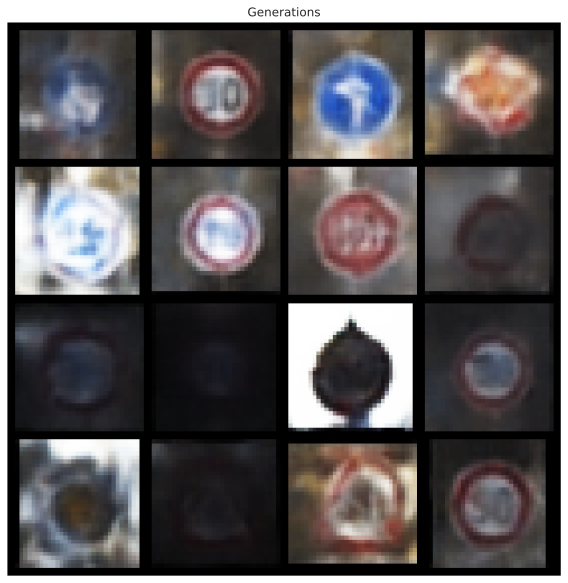

In [40]:
generate_images(model=vae, n_imgs=16, num_classes=num_classes, device=device)

In [69]:
generate_images_list(vae, device, imgs_per_class1)

tensor([[[[-0.7790, -0.7575, -0.7308,  ..., -0.8422, -0.8236, -0.8452],
          [-0.7593, -0.7468, -0.7168,  ..., -0.8312, -0.8191, -0.8412],
          [-0.7386, -0.7138, -0.7130,  ..., -0.8335, -0.8295, -0.8505],
          ...,
          [-0.7203, -0.6970, -0.7176,  ..., -0.8104, -0.8459, -0.8458],
          [-0.7410, -0.7158, -0.7380,  ..., -0.8210, -0.8583, -0.8563],
          [-0.7747, -0.7575, -0.7607,  ..., -0.8302, -0.8665, -0.8851]],

         [[-0.8260, -0.8083, -0.7864,  ..., -0.8489, -0.8341, -0.8586],
          [-0.8132, -0.7937, -0.7605,  ..., -0.8410, -0.8306, -0.8470],
          [-0.7826, -0.7631, -0.7530,  ..., -0.8467, -0.8423, -0.8652],
          ...,
          [-0.7350, -0.7170, -0.7245,  ..., -0.8280, -0.8524, -0.8557],
          [-0.7453, -0.7224, -0.7451,  ..., -0.8343, -0.8626, -0.8776],
          [-0.7843, -0.7634, -0.7637,  ..., -0.8371, -0.8735, -0.8953]],

         [[-0.8559, -0.8348, -0.8209,  ..., -0.8633, -0.8427, -0.8494],
          [-0.8384, -0.8172, -

In [ ]:
# img = data_set[0][0]
# grid = torchvision.utils.make_grid(img, nrow=4, normalize=False)
# grid = grid.permute(1, 2, 0)
# plt.figure(figsize=(15,10))
# plt.title(f"Generations")
# plt.imshow(grid)
# plt.axis('off')
# plt.show()

In [ ]:
# num_epochs = 30
# net = Encoder(3,64,32).to(device)
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(net.parameters(), lr=0.0005)


# for epoch in range(num_epochs):  # loop over the dataset multiple times

#     running_loss = 0.0
#     for i, data in enumerate(trainloader, 0):
#         # get the inputs; data is a list of [inputs, labels]
#         inputs, labels = data
#         inputs, labels = inputs.to(device), labels.to(device)

#         # zero the parameter gradients
#         optimizer.zero_grad()

#         # forward + backward + optimize
#         outputs = net(inputs)
#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()

#         # print statistics
#         running_loss += loss.item()

#     print('[%d/%d] loss: %.3f' %
#           (epoch+1 ,  num_epochs, running_loss / 2000))
#     running_loss = 0.0

# print('Finished Training')